## Sea ice drift directions and sea level pressure

In [1]:
import xarray as xr
import numpy as np
import cmocean
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import rotate_vector, polar_stereo, extend_grid_edges
from nemo_python_git.plots import circumpolar_plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
import matplotlib.path as mpath
import matplotlib.colors as cl

In [3]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_dir  = f'{base_dir}output/ERA5_test7/'

In [8]:
gridT_files = np.sort(glob.glob(f'{run_dir}files/*grid_T*'))
ice_files   = np.sort(glob.glob(f'{run_dir}files/*icemod*'))

domcfg  = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20240305.nc')
ds_mesh = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20240305.nc')

kwagsT   = {'preprocess':lambda ds: ds[['zos', 'time_counter']], 'chunks':'auto'}
kwagsice = {'preprocess':lambda ds: ds[['sivelu', 'sivelv', 'siconc', 'sivelo', 'sidive', 'sishea', 'time_counter']], 'chunks':'auto'}
ds_gridT = xr.open_mfdataset(gridT_files[24:32], **kwagsT).rename({'x_grid_T':'x','y_grid_T':'y', 'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat'}) #[24:32]
ds_ice   = xr.open_mfdataset(ice_files[24:32], **kwagsice)

ds_gridT = ds_gridT.where(ds_gridT!=0).where(ds_ice.siconc!=0)
ds_ice   = ds_ice.where(ds_ice!=0)
ice_mask = xr.open_mfdataset(ice_files[24:32])[['siconc']]

Plots: sea ice drift velocity vectors (annual + by season) with in background: sea ice concentration, sea level pressure

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html

In [9]:
def make_fig_circle(ax):
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Draw meridian lines with labels around circular boundary
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, xlocs=range(-180,171,30), ylocs=[], \
                      color='gray', alpha=0.5, linestyle='--', zorder=3)
    gl.xlabel_style = {'size': 8}
    # Draw concentric circles (but hide labels) for the parallels of the latitude
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, xlocs=[], ylocs=None, \
                    color='gray', alpha=0.5, linestyle='--', zorder=3)
    
    return ax

In [10]:
def subplot_quiver(fig, ax, ds, u, v, var='siconc', nemo_mesh=f'{base_dir}bathymetry/mesh_mask-20240305.nc', 
                   vmin=None, vmax=None, cmap='viridis', quiver_color='crimson', colorbar=True):
    
    subset  = {'x':slice(0,None,18), 'y':slice(0,None,14)}
    ds_mesh = xr.open_dataset(nemo_mesh)
    tmask   = ds_mesh.tmask.isel(time_counter=0, nav_lev=0)
    
    # Limit the map to -60 degrees latitude and below:
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax = make_fig_circle(ax)
    ax.set_facecolor('gray')
    ax.pcolormesh(ds_mesh.nav_lon, ds_mesh.nav_lat, tmask.where(tmask==1), cmap=cl.ListedColormap(['white']), transform=ccrs.PlateCarree())
    
    # Plot the data as usual
    cm = ax.pcolormesh(ds.nav_lon, ds.nav_lat, ds[var], transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
    if colorbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.8, 0.17, 0.02, 0.25])
        try:
            cb = fig.colorbar(cm, cax=cbar_ax, label=ds[var].long_name, extend='both')
        except:
            cb = fig.colorbar(cm, cax=cbar_ax, label=var, extend='both')
        cb.ax.tick_params(labelsize=8)    

    # add quiver arrows
    ql = ax.quiver(ds_mesh.nav_lon.isel(**subset).values, ds_mesh.nav_lat.isel(**subset).values, u.isel(**subset).values, v.isel(**subset).values, 
                   transform=ccrs.PlateCarree(), headlength=2.5, headwidth=2.5, headaxislength=2.5,  width=4e-3, scale=3.5, color=quiver_color)
    ax.quiverkey(ql, 0.4, 0.48, 0.1, '0.1 m/s', labelpos='E', zorder=4)
    
    return

In [11]:
ds_ice_annual   = ds_ice.mean(dim='time_counter', keep_attrs=True)
ds_gridT_annual = ds_gridT.mean(dim='time_counter', keep_attrs=True)

In [47]:
msl_files = glob.glob(f'{base_dir}ERA5-forcing/files/era5_msl_*_daily_averages.nc')[24:32]
kwags_msl = {'preprocess':lambda ds: ds[['msl', 'longitude', 'latitude']], 'chunks':'auto'}
slp = xr.open_mfdataset(msl_files, **kwags_msl).sel(latitude=slice(-50,-90))
slp['msl'] = slp['msl']*9.87e-6

In [114]:
tmask = ds_mesh.tmask.isel(time_counter=0, nav_lev=0)

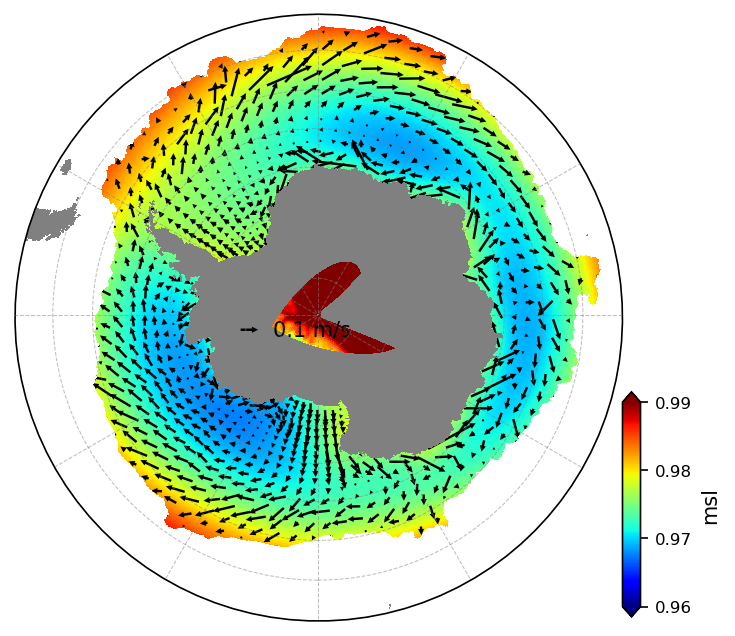

In [115]:
fig, ax = plt.subplots(1,1, figsize=(6,6), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

u_rot, v_rot = rotate_vector(ds_ice_annual['sivelu'], ds_ice_annual['sivelv'], domcfg, gtype='T', periodic=True, halo=True)
subplot_quiver(fig, ax, slp.mean(dim='time').rename({'longitude':'nav_lon','latitude':'nav_lat'}), 
               u_rot, v_rot, var='msl', vmin=0.96, vmax=0.99, cmap='jet', quiver_color='k')

ice_edge_mask = ds_mesh.tmask.isel(time_counter=0, nav_lev=0).where(ds_mesh.tmask.isel(time_counter=0, nav_lev=0)==1)
ice_edge_mask = xr.where(ice_mask.mean(dim='time_counter').siconc!=0, np.nan, ice_edge_mask)
ax.pcolormesh(ds_mesh.nav_lon, ds_mesh.nav_lat, ice_edge_mask, cmap=cl.ListedColormap(['white']), transform=ccrs.PlateCarree())
ax.pcolormesh(ds_mesh.nav_lon, ds_mesh.nav_lat, tmask.where(tmask==0), cmap=cl.ListedColormap(['Grey']), transform=ccrs.PlateCarree())

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

u_rot, v_rot = rotate_vector(ds_ice_annual['sivelu'], ds_ice_annual['sivelv'], domcfg, gtype='T', periodic=True, halo=True)
subplot_quiver(fig, ax, ds_ice_annual, u_rot, v_rot, var='sidive', vmin=-1e-7, vmax=1e-7, cmap=cmocean.cm.balance)

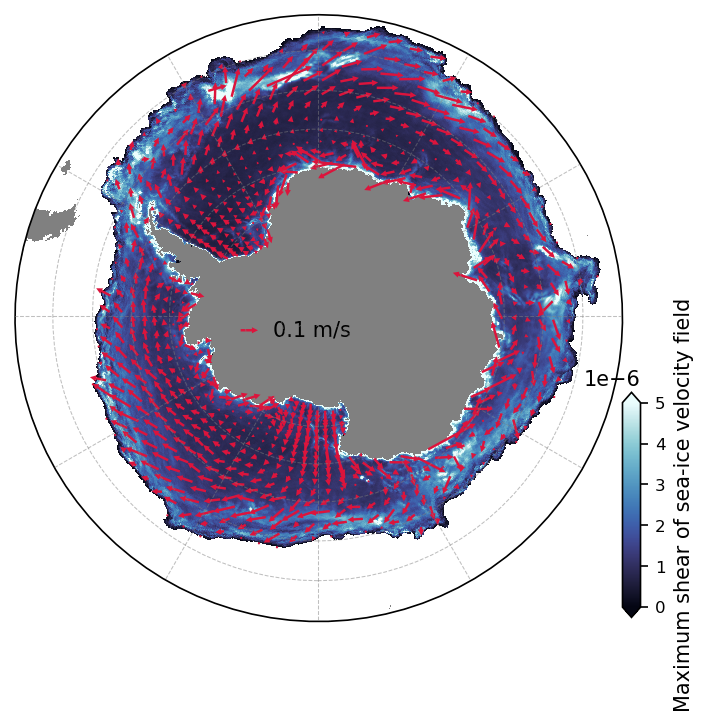

In [19]:
fig, ax = plt.subplots(1,1, figsize=(6,6), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

u_rot, v_rot = rotate_vector(ds_ice_annual['sivelu'], ds_ice_annual['sivelv'], domcfg, gtype='T', periodic=True, halo=True)
subplot_quiver(fig, ax, ds_ice_annual, u_rot, v_rot, var='sishea', vmin=0, vmax=5e-6, cmap=cmocean.cm.ice)

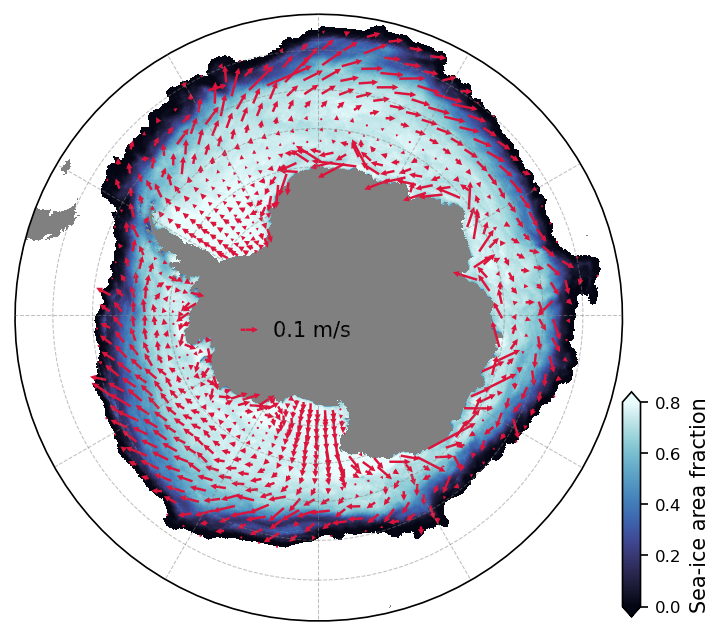

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,6), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

u_rot, v_rot = rotate_vector(ds_ice_annual['sivelu'], ds_ice_annual['sivelv'], domcfg, gtype='T', periodic=True, halo=True)
subplot_quiver(fig, ax, ds_ice_annual, u_rot, v_rot, var='siconc', vmin=0, vmax=0.8, cmap=cmocean.cm.ice)

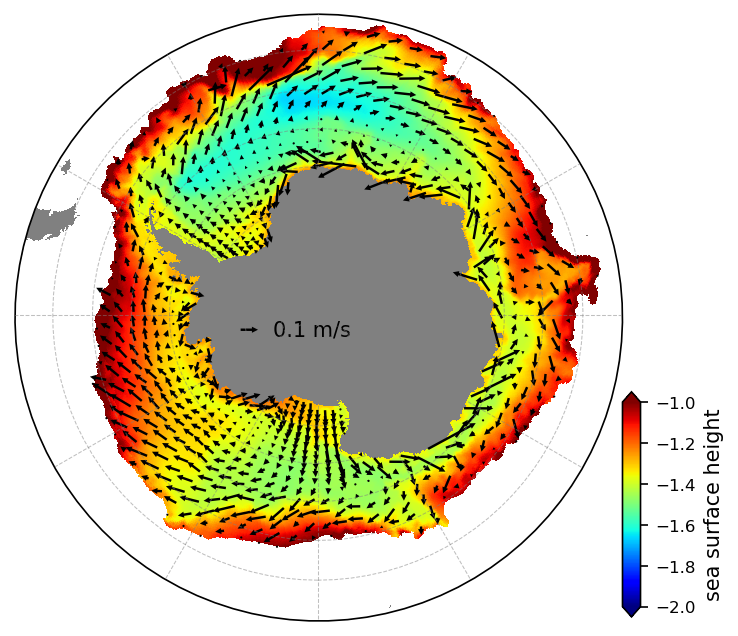

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,6), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

u_rot, v_rot = rotate_vector(ds_ice_annual['sivelu'], ds_ice_annual['sivelv'], domcfg, gtype='T', periodic=True, halo=True)
subplot_quiver(fig, ax, ds_gridT_annual, u_rot, v_rot, var='zos', vmin=-2, vmax=-1, cmap='jet', quiver_color='k')

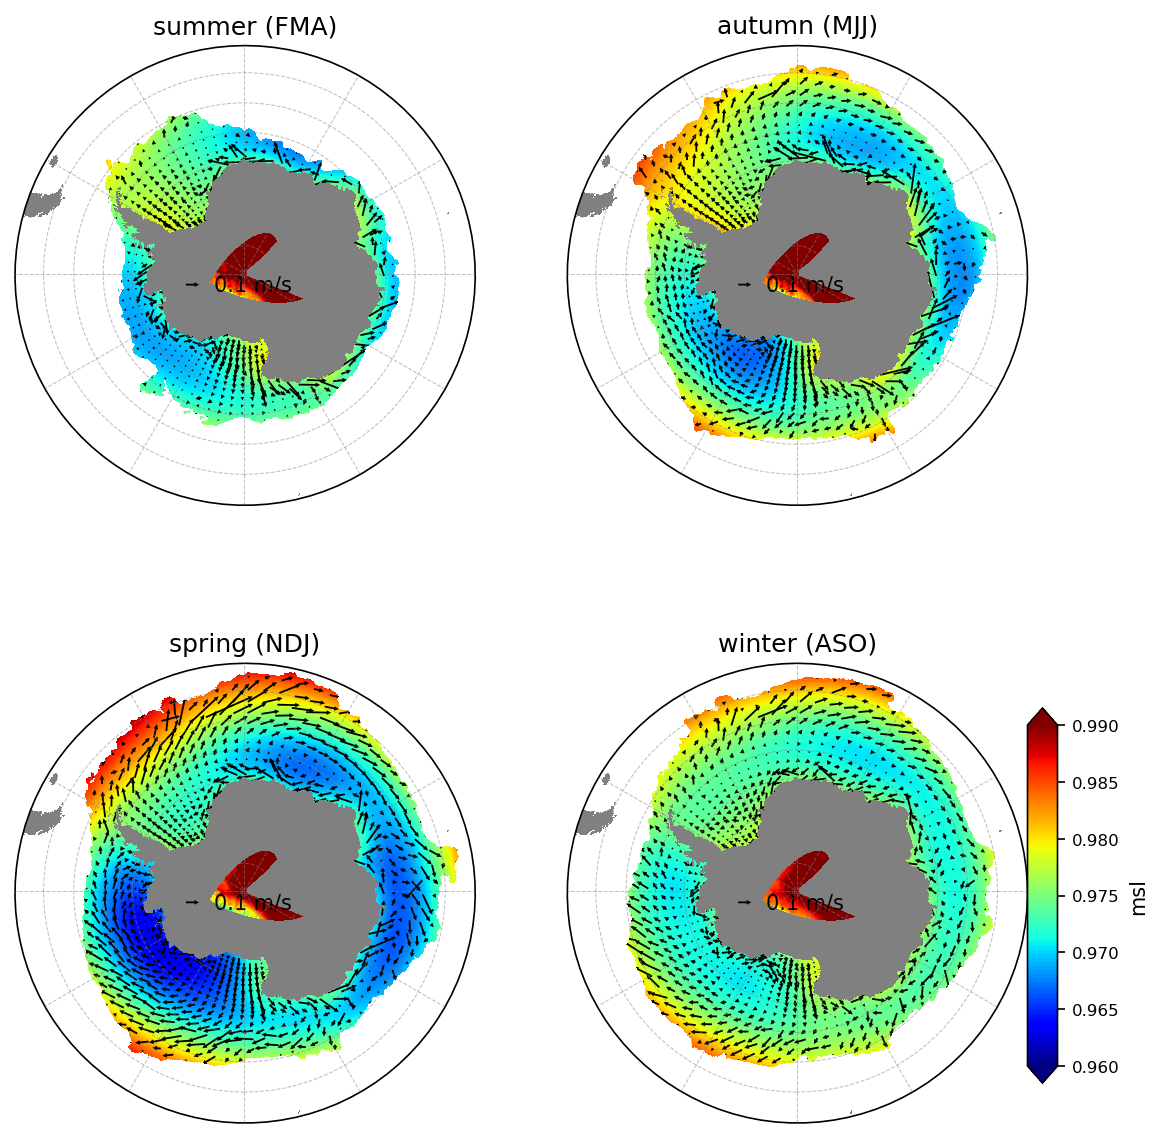

In [117]:
fig, ax = plt.subplots(2,2, figsize=(10,10), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

season_months = [[2,3,4], [5,6,7], [8,9,10], [11,12,1]]
season_names  = ['summer (FMA)', 'autumn (MJJ)', 'spring (NDJ)', 'winter (ASO)']

for a, axis in enumerate(ax.ravel()):
    slp_season = slp.isel(time=slp.time.dt.month.isin(season_months[a])).mean(dim='time', keep_attrs=True).rename({'longitude':'nav_lon','latitude':'nav_lat'})
    ds_ice_season = ds_ice.isel(time_counter=ds_ice.time_counter.dt.month.isin(season_months[a])).mean(dim='time_counter', keep_attrs=True)
    u_rot, v_rot  = rotate_vector(ds_ice_season['sivelu'], ds_ice_season['sivelv'], domcfg, gtype='T', periodic=True, halo=True)
    if a > 0: kwags = {'colorbar':False, 'cmap':'jet'}
    else: kwags = {'colorbar':True, 'cmap':'jet'}
    subplot_quiver(fig, axis, slp_season, u_rot, v_rot, var='msl', vmin=0.96, vmax=0.99, quiver_color='k', **kwags)
    axis.set_title(season_names[a])

    ice_edge_mask = ds_mesh.tmask.isel(time_counter=0, nav_lev=0).where(ds_mesh.tmask.isel(time_counter=0, nav_lev=0)==1)
    ice_edge_mask = xr.where(ice_mask.isel(time_counter=ds_ice.time_counter.dt.month.isin(season_months[a])).mean(dim='time_counter').siconc!=0, np.nan, ice_edge_mask)
    axis.pcolormesh(ds_mesh.nav_lon, ds_mesh.nav_lat, ice_edge_mask, cmap=cl.ListedColormap(['white']), transform=ccrs.PlateCarree())
    axis.pcolormesh(ds_mesh.nav_lon, ds_mesh.nav_lat, tmask.where(tmask==0), cmap=cl.ListedColormap(['Grey']), transform=ccrs.PlateCarree())

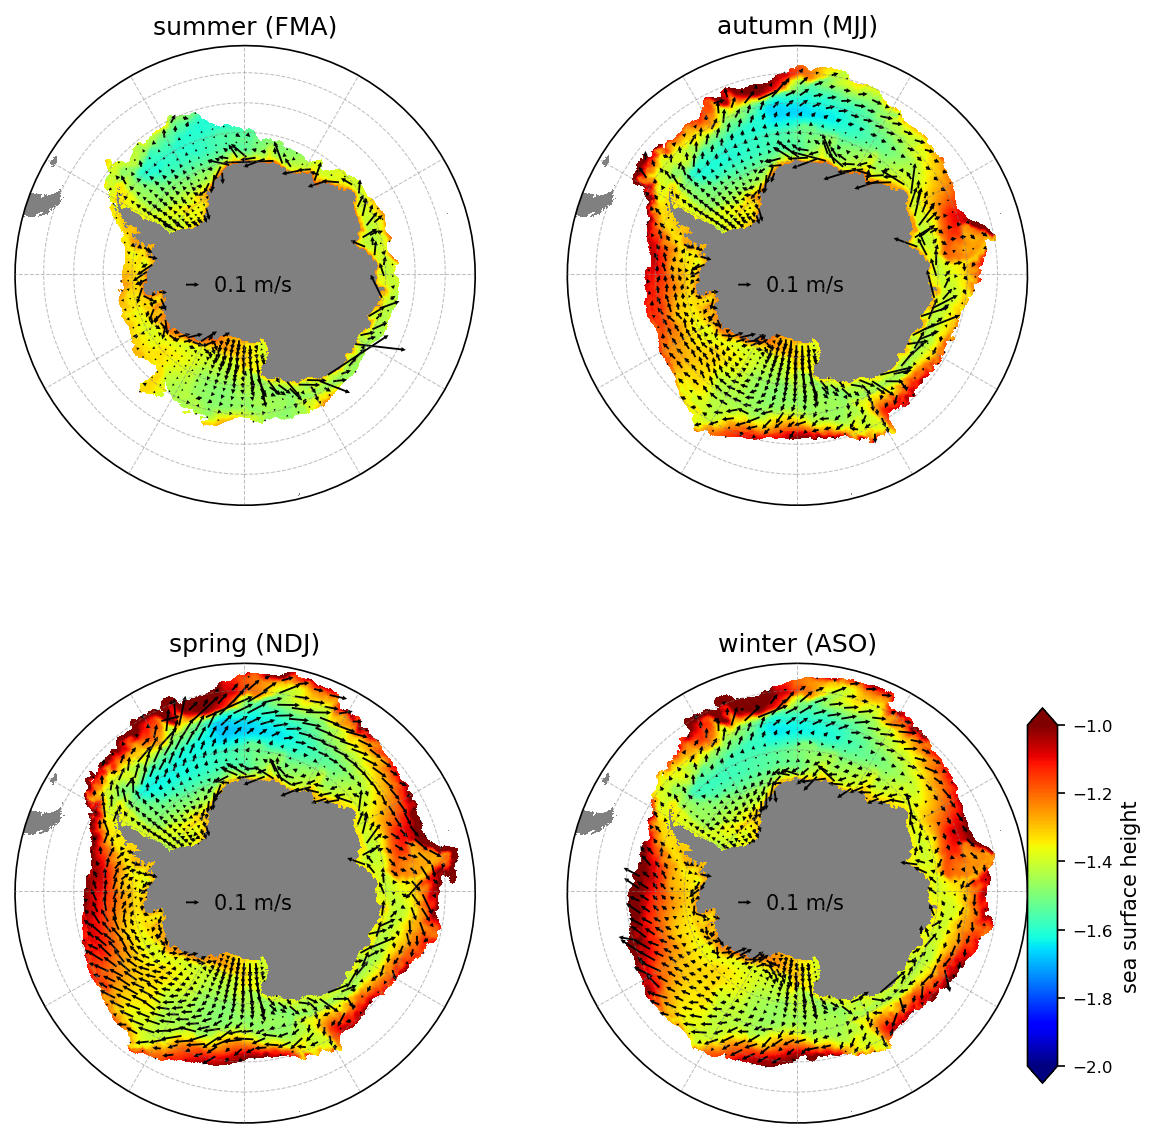

In [22]:
fig, ax = plt.subplots(2,2, figsize=(10,10), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

season_months = [[2,3,4], [5,6,7], [8,9,10], [11,12,1]]
season_names  = ['summer (FMA)', 'autumn (MJJ)', 'spring (NDJ)', 'winter (ASO)']

for a, axis in enumerate(ax.ravel()):
    ds_gridT_season = ds_gridT.isel(time_counter=ds_gridT.time_counter.dt.month.isin(season_months[a])).mean(dim='time_counter', keep_attrs=True)
    ds_ice_season = ds_ice.isel(time_counter=ds_ice.time_counter.dt.month.isin(season_months[a])).mean(dim='time_counter', keep_attrs=True)
    u_rot, v_rot  = rotate_vector(ds_ice_season['sivelu'], ds_ice_season['sivelv'], domcfg, gtype='T', periodic=True, halo=True)
    if a > 0: kwags = {'colorbar':False, 'cmap':'jet'}
    else: kwags = {'colorbar':True, 'cmap':'jet'}
    subplot_quiver(fig, axis, ds_gridT_season, u_rot, v_rot, var='zos', vmin=-2, vmax=-1, quiver_color='k', **kwags)
    axis.set_title(season_names[a])

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

season_months = [[2,3,4], [5,6,7], [8,9,10], [11,12,1]]
season_names  = ['summer (FMA)', 'autumn (MJJ)', 'spring (NDJ)', 'winter (ASO)']

for a, axis in enumerate(ax.ravel()):
    ds_ice_season = ds_ice.isel(time_counter=ds_ice.time_counter.dt.month.isin(season_months[a])).mean(dim='time_counter', keep_attrs=True)
    u_rot, v_rot  = rotate_vector(ds_ice_season['sivelu'], ds_ice_season['sivelv'], domcfg, gtype='T', periodic=True, halo=True)
    if a > 0: kwags = {'colorbar':False, 'cmap':cmocean.cm.balance}
    else: kwags = {'colorbar':True, 'cmap':cmocean.cm.balance}
    subplot_quiver(fig, axis, ds_ice_season, u_rot, v_rot, var='sidive', vmin=-1e-7, vmax=1e-7, **kwags)
    axis.set_title(season_names[a])

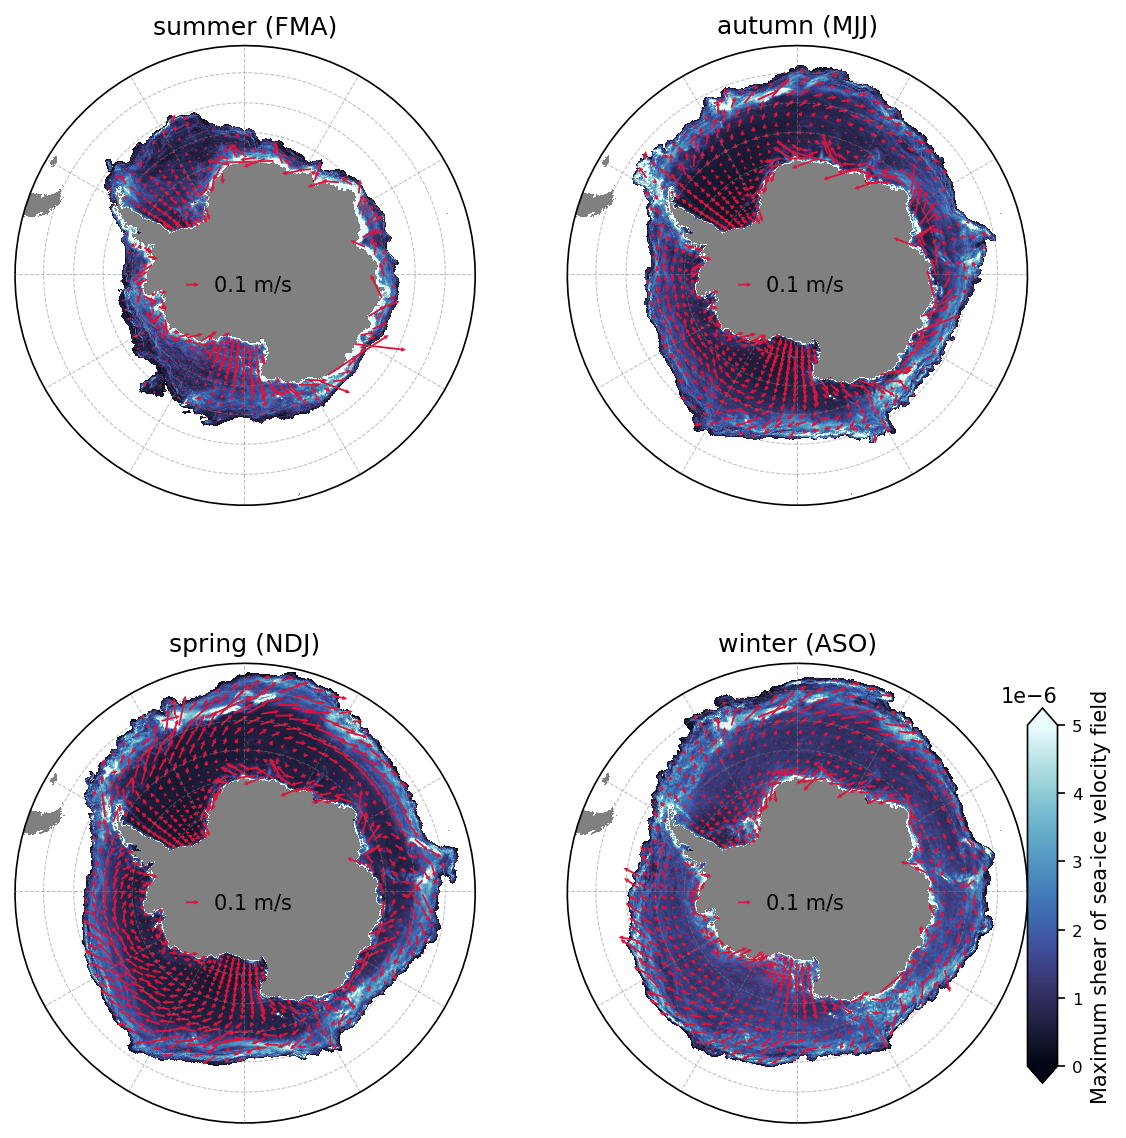

In [20]:
fig, ax = plt.subplots(2,2, figsize=(10,10), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

season_months = [[2,3,4], [5,6,7], [8,9,10], [11,12,1]]
season_names  = ['summer (FMA)', 'autumn (MJJ)', 'spring (NDJ)', 'winter (ASO)']

for a, axis in enumerate(ax.ravel()):
    ds_ice_season = ds_ice.isel(time_counter=ds_ice.time_counter.dt.month.isin(season_months[a])).mean(dim='time_counter', keep_attrs=True)
    u_rot, v_rot  = rotate_vector(ds_ice_season['sivelu'], ds_ice_season['sivelv'], domcfg, gtype='T', periodic=True, halo=True)
    if a > 0: kwags = {'colorbar':False, 'cmap':cmocean.cm.ice}
    else: kwags = {'colorbar':True, 'cmap':cmocean.cm.ice}
    subplot_quiver(fig, axis, ds_ice_season, u_rot, v_rot, var='sishea', vmin=0, vmax=5e-6, **kwags)
    axis.set_title(season_names[a])

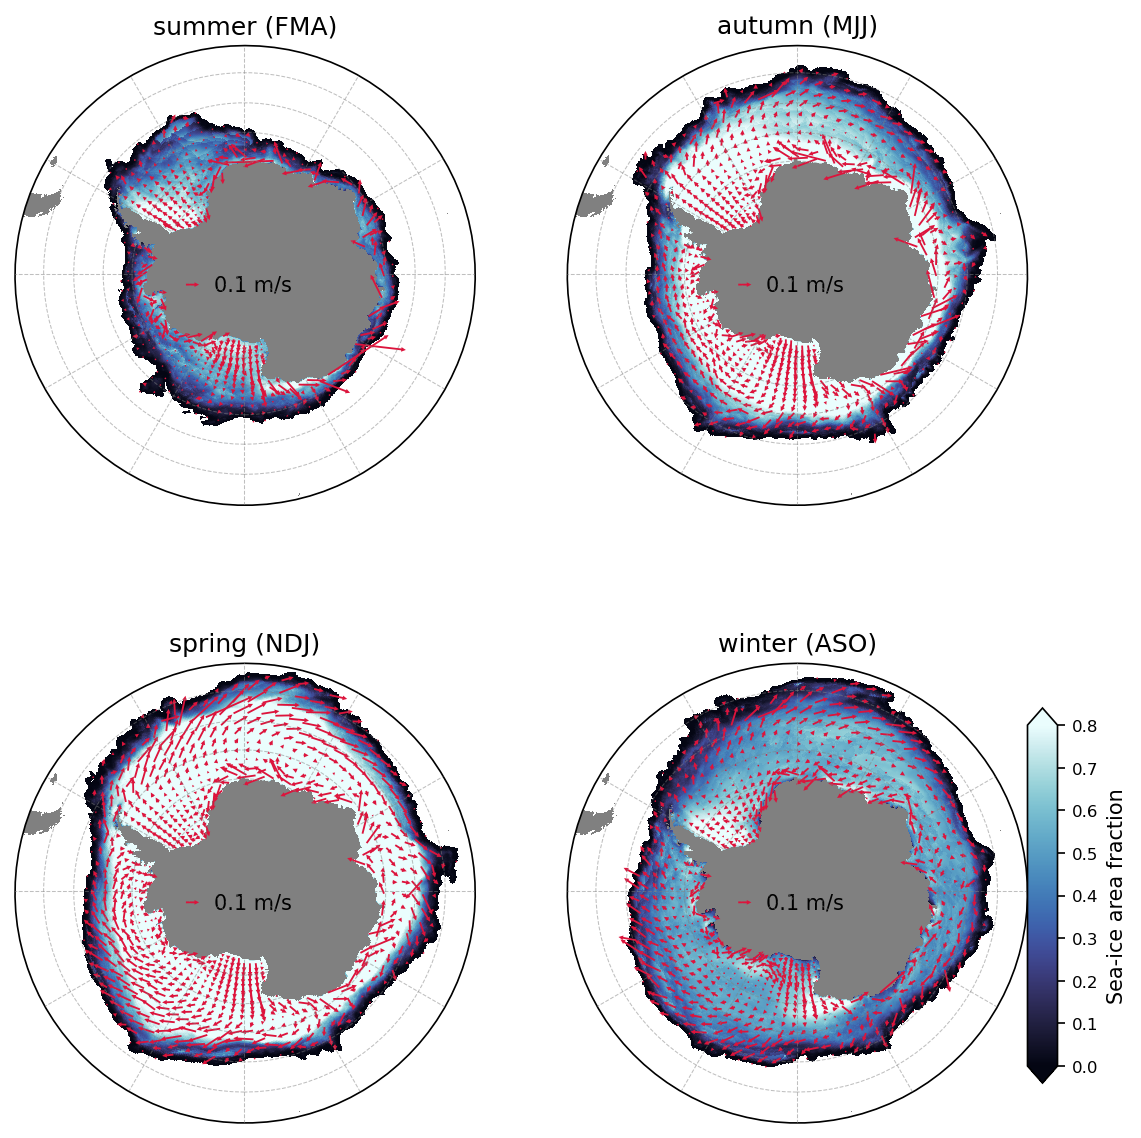

In [11]:
fig, ax = plt.subplots(2,2, figsize=(10,10), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

season_months = [[2,3,4], [5,6,7], [8,9,10], [11,12,1]]
season_names  = ['summer (FMA)', 'autumn (MJJ)', 'spring (NDJ)', 'winter (ASO)']

for a, axis in enumerate(ax.ravel()):
    ds_ice_season = ds_ice.isel(time_counter=ds_ice.time_counter.dt.month.isin(season_months[a])).mean(dim='time_counter', keep_attrs=True)
    u_rot, v_rot  = rotate_vector(ds_ice_season['sivelu'], ds_ice_season['sivelv'], domcfg, gtype='T', periodic=True, halo=True)
    if a > 0: kwags = {'colorbar':False, 'cmap':cmocean.cm.ice}
    else: kwags = {'colorbar':True, 'cmap':cmocean.cm.ice}
    subplot_quiver(fig, axis, ds_ice_season, u_rot, v_rot, var='siconc', vmin=0, vmax=0.8, **kwags)
    axis.set_title(season_names[a])